#  **Testing Gaussian EP on a given RBM**


In [1]:
using Pkg
using Plots
using Revise
using DelimitedFiles
using BenchmarkTools

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/disat/amuntoni/.julia/packages/Revise/9lZUE/src/packagedef.jl:1369


In [2]:
#include("../src/GaussianEP.jl")
#using .GaussianEP
include("../Sampling/Sampling.jl")
Pkg.activate("../../GaussianEP/")
using GaussianEP

  Activating environment at `~/GaussianEP/Project.toml`


In [ ]:
# Number of visible and hidden units, Gaussian weigths
N = 8
M = 3
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [ ]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M];


In [ ]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 100);

In [ ]:
using Plots

Σan = GaussianEP.compute_analytic(w,Pv,Ph)
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [ ]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 
Pv = nothing; Ph = nothing;
Pv = [GaussianEP.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for j = 1:M];


In [ ]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, epsconv = 1e-7, maxiter=100000);
cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

In [ ]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, Pv, Ph);

In [ ]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [ ]:
Pv = [Sampling.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [Sampling.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0mc = vcat(Pv,Ph);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.005:0.2)
@time acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 0.05
nblocks = 22
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
@time bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log, xlabel="MC sweeps", ylabel="Energy") 
plot(p1)


In [ ]:
# Sampling using MCMC
bl_tab = nothing
Nconf = 10^6
Twait = 10^6
@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

@time av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

In [ ]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Binary, ReLU) Priors

In [ ]:
using DelimitedFiles, JLD2
# Number of visible and hidden units, Gaussian weigths
N = convert(Int64, 28*28)
M = 400
#w = randn(N,M)
w = readdlm("../MNIST/winf_adam_lm534.txt",'\t', Float64, '\n')
mean_data = readdlm("../MNIST/mean.txt", '\t', Float64, '\n')
covv_data = readdlm("../MNIST/corr.txt", '\t', Float64, '\n')
par = load("../MNIST/rbm_priors.jld2")
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

Pv = par["P0"][1];
Ph = par["P0"][2];

In [ ]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 100, epsconv = 1e-5, maxiter = 100000);

cov_ep = zeros(N,M)
covv_ep = zeros(N,N) .* NaN
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end
for i = 1:N, j = i+1:N
	covv_ep[i,j] = out.state.Σ[i,j] + out.state.av[i] * out.state.av[j]
	covv_ep[j,i] = covv_ep[i,j]
end

va_data = zeros(N,)
for i = 1:N
	va_data[i] = covv_data[i,i] - mean_data[i] * mean_data[i]
	covv_data[i,i] = NaN
end
writedlm(open("../MNIST/mean_ep.dat", "w"), out.state.av)
writedlm(open("../MNIST/var_ep.dat", "w"), out.state.va)
writedlm(open("../MNIST/var_data.dat", "w"), va_data)
writedlm(open("../MNIST/covv_ep.dat", "w") , vec(covv_ep))
writedlm(open("../MNIST/covv_data.dat", "w"), vec(covv_data))


In [ ]:
γ_m = Ph[1].γ
θ_m = Ph[1].θ
println(γ_m, " ", θ_m)

ρ_m = Pv[1].ρ



In [ ]:
Pv = [Sampling.BinaryPrior(0.0, 1.0, ρ_m) for i = 1:N];
Ph = [Sampling.ReLUPrior(γ_m, θ_m) for j = 1:M];
P0mc = vcat(Pv,Ph);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.01:0.02:0.1)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 0.01
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC

mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.01
Nconf = 10^2
Twait = 10^5

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc, covv_mc = Sampling.compute_statistics(mc_out, N, M);
writedlm(open("../MNIST/samples.dat", "w"), mc_out)
mc_out = nothing

for i = 1:N
    covv_mc[i,i] = NaN
end

#writedlm(open("../MNIST/var_mc.dat", "w"), va_mc)
#writedlm(open("../MNIST/av_mc.dat", "w"), av_mc)
#writedlm(open("../MNIST/covv_mc.dat", "w"), vec(covv_mc))


In [ ]:

writedlm(open("../MNIST/var_mc.dat", "w"), va_mc)
writedlm(open("../MNIST/av_mc.dat", "w"), av_mc)
writedlm(open("../MNIST/covv_mc.dat", "w"), vec(covv_mc))
print(va_mc)

In [ ]:

p = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p = Plots.plot!(mean_data, out.av, aspect_ratio = :equal, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot!(mean_data, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel= "Data av")
p2 = Plots.plot(av_mc, out.av, seriestype = :scatter, label = "MC vs EP", legend = :topleft, xlabel = "MC", ylabel = "EP")
l = @layout [a{0.3h} b{0.3h} c{0.3h}]
Plots.plot(p, p1,p2, layout = l)

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC non-diag. cov")
#p6 = Plots.plot!(mean_data, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel= "Data av")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="Data covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "Data av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "Data va")
p5 = Plots.plot(vec(covv_data), vec(covv_data), label = "x = y")
p5 = Plots.plot!(vec(covv_data), vec(covv_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "Data non-diag. cov")
#p6 = Plots.plot!(mean_data, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel= "Data av")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [ ]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
θ = 1.0
μv = 0.0; βv = 10.0; # βv needs to be large

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.ReLUPrior(γ, θ, 1e-2, 0.0) for j = 1:M ];

In [ ]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 50, epsconv = 1e-5, maxiter = 100000)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

In [ ]:
γ_m = Ph[1].γ
θ_m = Ph[1].θ
println(γ_m, " ", θ_m)

In [ ]:
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [Sampling.ReLUPrior(γ_m, θ_m) for j = 1:M ]

P0mc = vcat(Pv,Ph);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:

# Get thermalization time

Δ = 0.9
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC

mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.1
Nconf = 5 * 10^5
Twait = 10^6

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

In [ ]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (SpikeAndSlab, ReLu) priors

In [ ]:

# Number of visible and hidden units, Gaussian weigths
#N = convert(Int,28*28*0.5)
#M = convert(Int,400*0.5)
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
ρ = 1.0/21
λ = 50.0
Pv = [GaussianEP.SpikeSlabPrior(ρ, λ, 0.0, 1e-3) for i = 1:N]
Ph = [GaussianEP.ReLUPrior(γ, 0.0, 1e-3, 1e-3) for i = 1:M]


In [ ]:

out = GaussianEP.expectation_propagation(H, Pv, Ph, epsconv = 1e-5, nprint = 100)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end


In [ ]:


γ_m = Ph[1].γ
θ_m = Ph[1].θ
λ_m = Pv[1].λ
println("γ: ",γ_m, " θ: ", θ_m, " λ: ", λ_m)
Pv = [Sampling.SpikeSlabPrior(ρ, λ_m) for i = 1:N]
Ph = [Sampling.ReLUPrior(γ_m, θ_m) for j = 1:M ]
P0mc = vcat(Pv,Ph);

In [ ]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.5:0.5:3.0)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 3.5
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 3.5
Nconf = 10^6
Twait = 10^5

@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

@time av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, Spike and Slab)

In [ ]:

# Number of visible and hidden units, Gaussian weigths
#N = 30
#M = 15
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
ρ = 0.2
λ = 20.0
μv = 0.5
βv = 50.0

Ph = [GaussianEP.SpikeSlabPrior(ρ, λ) for i = 1:M]
Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];


In [ ]:
out = GaussianEP.expectation_propagation(H, Pv, Ph, nprint = 100);

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

In [ ]:
Phtype = Sampling.SpikeSlabPrior(ρ, λ)

Ph = [Phtype for i = 1:M]
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
P0mc = vcat(Pv,Ph);

In [ ]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.1:0.1:1.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 0.5
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:

# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Nconf = 5*10^6
Twait = 10^4

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Ph,Pv) = (Binary, Binary) for MNIST

In [3]:
using JLD2

mean_data = readdlm("../MNIST/mean.txt", '\t', Float64, '\n')
covv_data = readdlm("../MNIST/corr.txt", '\t', Float64, '\n')
data_EP = load("../MNIST/res_BerRBM_rh8_w0bim_adagrad_SGD_epTRBL.jld2");
w_EP = data_EP["res"].weights;


┌ Warning: type parameters for NamedTuple{(:weights, :likelihood, :state, :opt, :grad),Tuple} do not match type NamedTuple in workspace; reconstructing
└ @ JLD2 /home/disat/amuntoni/.julia/packages/JLD2/sFiXk/src/data/reconstructing_datatypes.jl:430
┌ Warning: type epRBM.Adagrad{Float64,Int64} does not exist in workspace; reconstructing
└ @ JLD2 /home/disat/amuntoni/.julia/packages/JLD2/sFiXk/src/data/reconstructing_datatypes.jl:450


In [4]:

N,M = size(w_EP)
rhov = 0.8677
rhoh = 0.8
Pv = BinaryPrior(0.0, 1.0, rhov)
Ph = BinaryPrior(0.0, 1.0, rhoh)
y = zeros(N+M)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);
H = [GaussianEP.TermRBM(w_EP,y,1.0)];

out_ep = expectation_propagation(H,P0, nprint = 1000, maxiter = 10000, damp = 0.99, epsconv = 1e-5);



it: 1000 Δav: 0.0001569795143511188 Δgrad: 0.0
it: 2000 Δav: 0.00028957215786551416 Δgrad: 0.0
it: 3000 Δav: 9.3358607111238e-5 Δgrad: 0.0
it: 4000 Δav: 1.4142016603602148e-5 Δgrad: 0.0


In [5]:
using BoltzmannMachines
data_bm = load("../MNIST/winf_fields_BerRBM.jld2")
w_BM = data_bm["res"].weights
rhov_BM = 1.0 ./ (1.0 .+ exp.(data_bm["res"].visbias));
rhoh_BM = 1.0 ./ (1.0 .+ exp.(data_bm["res"].hidbias));

Pv = [BinaryPrior(0.0,1.0,rhov_BM[i]) for i = 1:N]
Ph = [BinaryPrior(0.0,1.0,rhoh_BM[i]) for i = 1:M]

P0_BM = vcat(Pv,Ph);

H_BM = [GaussianEP.TermRBM(w_BM,y,1.0)];
out_BM = expectation_propagation(H_BM,P0_BM,nprint = 1000, damp= 0.99, epsconv = 1e-5, maxiter = 10000)

it: 1000 Δav: 0.0003937884605880737 Δgrad: 0.0
it: 2000 Δav: 5.2805850441983715e-5 Δgrad: 0.0
it: 3000 Δav: 1.194022329553679e-5 Δgrad: 0.0


EPOut{Float64}([0.0003401950475130394, 0.00017959588446573723, 0.0002245484301055047, 0.0003246758715611995, 0.00024314829105118245, 0.00022970204704711393, 0.0002920639829825623, 0.0002801464973977917, 0.0002501596685064938, 0.0003101478334405337  …  0.6615280603635035, 0.3154979839803541, 0.5301253649976868, 0.2491325364101213, 0.6589911863425166, 0.18327122969902165, 0.7208430004359303, 0.8545505458486252, 0.6804242824222667, 0.7130643981515383], [0.000340079314842687, 0.0001795636297840202, 0.00022449800810804186, 0.00032457045713962546, 0.00024308916995974134, 0.0002296492840166963, 0.00029197868161240663, 0.0002800680153377874, 0.0002500970886467465, 0.0003100516417619458  …  0.22390868571520434, 0.21595900608468632, 0.24909246238375615, 0.18706551571198088, 0.22472180266539915, 0.1496828860636301, 0.20122836915845566, 0.12429391043844196, 0.2174470783124101, 0.20460356224032272], [34.48055457297344, 35.57032008507923, 36.02248887891261, 29.06217888486137, 35.17834937000661, 33.6

In [7]:
covv_ep = zeros(N,N)
for i = 1:N, j = i+1:N
	covv_ep[i,j] = out_ep.state.Σ[i,j] + out_ep.state.av[i] * out_ep.state.av[j]
	covv_ep[j,i] = covv_ep[i,j]
end

va_data = zeros(N,)
for i = 1:N
	va_data[i] = covv_data[i,i] - mean_data[i] * mean_data[i]
	covv_data[i,i] = NaN
end

covv_bm = zeros(N,N)
for i = 1:N, j = i+1:N
	covv_bm[i,j] = out_BM.state.Σ[i,j] + out_BM.state.av[i] * out_BM.state.av[j]
	covv_bm[j,i] = covv_bm[i,j]
end


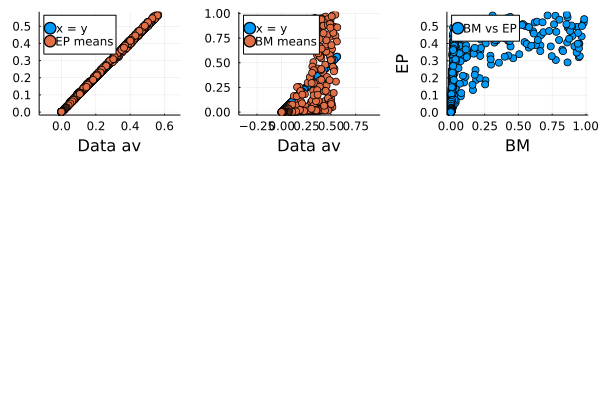

In [9]:
p = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p = Plots.plot!(mean_data, out_ep.av[1:N], aspect_ratio = :equal, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot(mean_data, mean_data, aspect_ratio = :equal, seriestype = :scatter, label = "x = y", legend = :topleft, xlabel= "Data av")
p1 = Plots.plot!(mean_data, out_BM.av[1:N], seriestype = :scatter, label = "BM means", legend = :topleft, xlabel= "Data av")
p2 = Plots.plot(out_BM.av[1:N], out_ep.av[1:N], seriestype = :scatter, label = "BM vs EP", legend = :topleft, xlabel = "BM", ylabel = "EP")
l = @layout [a{0.3h} b{0.3h} c{0.3h}]
Plots.plot(p, p1,p2, layout = l)